학습데이터셋 크기  40000
검증데이터셋 크기  5000
Training start!


  0%|          | 0/312 [00:00<?, ?it/s]

epoch 1/5, val loss: 0.0093


  0%|          | 0/312 [00:00<?, ?it/s]

epoch 2/5, val loss: 0.0007


  0%|          | 0/312 [00:00<?, ?it/s]

epoch 3/5, val loss: 0.0006


  0%|          | 0/312 [00:00<?, ?it/s]

epoch 4/5, val loss: 0.0006


  0%|          | 0/312 [00:00<?, ?it/s]

epoch 5/5, val loss: 0.0005
Training finished!


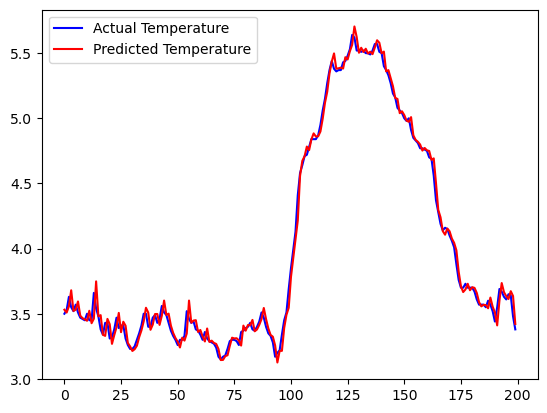

In [4]:
import urllib.request
import zipfile
import os

url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_filename = "jena_climate_2009_2016.csv.zip"
csv_filename = "jena_climate_2009_2016.csv"

# 파일 다운로드 (zip 파일이 없을 때만)
if not os.path.exists(zip_filename):
    urllib.request.urlretrieve(url, zip_filename)

# 압축 해제 (csv 파일이 없을 때만)
if not os.path.exists(csv_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(".")
        
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# 데이터셋
class JenaTemperatureDataset(Dataset):
    def __init__(self, temperatures, sequence_length):
        self.temperatures = temperatures
        self.sequence_length = sequence_length

    def __getitem__(self, index):
        inputs = self.temperatures[index:index+self.sequence_length]
        targets = self.temperatures[index+1:index+self.sequence_length+1]
        # shape 맞추기
        inputs = torch.tensor(inputs).reshape(-1, 1)      # (sequence_length, 1)
        targets = torch.tensor(targets).reshape(-1, 1)    # (sequence_length, 1)
        return inputs, targets

    def __len__(self):
        return len(self.temperatures) - self.sequence_length

# 모델
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)

        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0

    for inputs, targets in tqdm(train_loader, leave=False, disable=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

    train_loss = running_loss / total
    return train_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_loader:
            inputs = val_batch[0].to(device)
            targets = val_batch[1].to(device)
            preds = model(inputs)
            loss = criterion(preds, targets)
            losses.append(loss.item())

    val_loss_avg = sum(losses) / len(losses)
    return val_loss_avg  # 반환 추가

def data_load():
    # 데이터 불러오기
    df = pd.read_csv('./jena_climate_2009_2016.csv')
    # 기온 데이터 추출
    temperatures = df[['T (degC)']].to_numpy().astype(np.float32)
    temperatures = temperatures[:50000]

    # 학습/검증/테스트 분할
    num_data = len(temperatures)
    train_size = int(num_data * 0.8)
    val_size = int(num_data * 0.1)

    print('학습데이터셋 크기 ', train_size)
    print('검증데이터셋 크기 ', val_size)

    train_data = temperatures[:train_size]
    val_data = temperatures[train_size:train_size + val_size]
    test_data = temperatures[train_size + val_size:]

    # 표준화
    scaler = StandardScaler()
    scaler.fit(train_data)

    train_data_scaled = scaler.transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    train_dataset = JenaTemperatureDataset(train_data_scaled, sequence_length)
    val_dataset = JenaTemperatureDataset(val_data_scaled, sequence_length)
    test_dataset = JenaTemperatureDataset(test_data_scaled, sequence_length)

    # 데이터로더
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128)
    test_dataloader = DataLoader(test_dataset, batch_size=128)

    # 테스트 데이터 10개
    train_dataset = JenaTemperatureDataset(train_data_scaled[:10 + sequence_length], sequence_length)
    val_dataset = JenaTemperatureDataset(val_data_scaled[:10 + sequence_length], sequence_length)
    test_dataset = JenaTemperatureDataset(test_data_scaled[:10 + sequence_length], sequence_length)
    
    return train_dataloader, val_dataloader, test_dataloader, scaler, test_data

sequence_length = 24
train_dataloader, val_dataloader, test_dataloader, scaler, test_data = data_load()

model = LSTMModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

print('Training start!')

epochs = 5
for epoch in range(epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device)
    val_loss = evaluate(model, val_dataloader, loss_fn, device)
    print(f'epoch {epoch+1}/{epochs}, val loss: {val_loss:.4f}')
    
print('Training finished!')

test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_dataloader:
        inputs = test_batch[0].to(device)
        preds = model(inputs) # [batch size, sequence length, 1]
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)
    
test_targets = test_data[sequence_length:]
import matplotlib.pyplot as plt

plt.plot(test_targets[:200, 0], color='blue', label='Actual Temperature')
plt.plot(test_preds[:200, 0], color='red', label='Predicted Temperature')
plt.legend()
plt.show()